# _Spectrogram_, _Cepstrogram_ y _LPCtrogram_

Procesamiento del Habla (66.46) - FIUBA

### Librerías usadas

In [26]:
import numpy as np

%matplotlib notebook
from matplotlib import pyplot as plt

from scipy.io.wavfile import read as wavread, write as wavwrite
from scipy.signal import spectrogram, freqz
from scipy.linalg import toeplitz, inv

### Funciones auxiliares

In [21]:
# loads a WAV file
def load(path):
    
    Fs, x = wavread(path)

    if x.dtype == 'int16':
        nb_bits = np.float(16)
        x = x / 2**(nb_bits-1)
    elif x.dtype == 'int32':
        nb_bits = np.float(32)
        x = x / 2**(nb_bits-1)
    elif x.dtype == 'uint8':
        x = x / 2**8

    x = x.astype(np.float64)

    return x, Fs

# computes the FFT
def fft(x, nfft=None):
    return np.fft.fft(x, len(x) if nfft is None else nfft)

# computes the IFFT
def ifft(x):
    return np.fft.ifft(x)

# plot x-trogram
def plot_xtrogram(t, f, Sxx, title, name):

    fig, ax = plt.subplots()

    fig.suptitle(title)
    ax.pcolormesh(t, f, np.log(np.abs(Sxx)))
    ax.set(xlabel='Time [s]', ylabel='Frequecy [Hz]')
    ax.set_ylim(0, Fs/2)
    ax.plot()
    
    plt.show()

def sampler(x, Fs, resolve, **kwargs):
    
    samples_window = round(Fs * 0.025)
    t = np.arange(len(x)) / Fs
    end_time = t[-1]
    samples = []

    for offset in np.arange(0.0, end_time - 0.025, 0.010) * Fs:

        offset = int(offset)

        # Gets signal window at [offset:offset+samples_window)
        window = x[offset:(offset + samples_window)]

        res = resolve(window, kwargs)

        samples.append(res)

    H_mat = np.array(samples).T
    
    return H_mat

### _Plotting_

In [20]:
def plot(x, Fs):

    t = np.arange(len(x)) / Fs
    
    fig, ax = plt.subplots()

    fig.suptitle("Fantasia")
    ax.set(xlabel='Time [s]', ylabel='Amplitud')
    
    ax.plot(t, x)
    
    plt.show()

In [4]:
def plot_spectrogram(x, Fs):
    
    n_perseg = int(0.025 * Fs)
    window = 'hanning'
    detrend='constant'
    return_onesided=True
    scaling='density'
    axis=-1
    mode='psd'
    Nfft = n_perseg * 8

    f, t, Sxx = spectrogram(x, window=window, fs=Fs,
                            nperseg=n_perseg, nfft=Nfft,
                            detrend=detrend, return_onesided=return_onesided,
                            scaling=scaling, axis=axis, mode=mode)
    
    plot_xtrogram(t, f, Sxx, title='Spectrogram', name='spectrogram')

In [5]:
def plot_cepstrogram(x, Fs):
    
    H_mat = cepstrogram(x, Fs)
        
    NF, NT = H_mat.shape

    f = np.arange(NF) * Fs / NF
    t = np.arange(NT) * 0.010
    
    plot_xtrogram(t, f, H_mat, title='Cepstrogram', name='cepstrogram')

In [6]:
def plot_lpctrogram(x, Fs):
    
    H_mat = lpctrogram(x, Fs)
    
    NF, NT = H_mat.shape

    f = np.arange(NF) * (Fs / 2) / NF
    t = np.arange(NT) * 0.010

    plot_xtrogram(t, f, H_mat, title='LPCtrogram', name='lpctrogram')

### _Cepstrogram_

In [7]:
def resolve_ceps(window, kwargs):
    
    N = kwargs['N']
    
    # Gets the FFT of the window
    S_win = fft(window, nfft=8*len(window))

    # Gets the cepstrum _s(n) = IFFT(log(|S|))
    _s = ifft(np.log(np.abs(S_win)))

    # Build time filter
    # to remove the x part
    filt = np.zeros(len(_s))

    for i in range(N):
        filt[i] = 1
    for i in range(len(filt)-(N-1), len(filt)):
        filt[i] = 1

    _h = _s * filt

    # Gets the FFT of the _h
    _H = np.abs(np.exp(fft(_h)))
    
    return _H
    
def cepstrogram(x, Fs):
    
    H_mat = sampler(x, Fs, resolve_ceps, N=80)
    
    return H_mat

### _LPCtrogram_

In [50]:
def resolve_lpc(window, kwargs):
    
    M = kwargs["M"]
    
    # Finds the correlation function
    # which will be used for 'rho' stimation
    rho = np.correlate(window, window, "full")

    # The 'M' rho stimators are taken from
    # the middle of the correlation function
    stimate = rho[len(rho)//2:(len(rho)//2 + M)]

    # Build the 'toeplitz' matrix.
    # Find its inverse and calculate
    # the 'a' coefficients
    mat = toeplitz(stimate[:(M-1)])
    a = inv(mat).dot(stimate[1:])

    # Calculates the 'gain' filter parameter
    gain = stimate[0]

    for i in range(1, len(a)):
        gain += stimate[i] * a[i]

    # Frequecy from the Filter
    w, h = freqz([1], [1] + list(a*(-1)))

    _H = np.abs(h)*gain
    
    return _H

def lpctrogram(x, Fs):
    
    M = 20
    
    H_mat = sampler(x, Fs, resolve_lpc, M=M)

    return H_mat

### Analisis: _fantasia.wav_

In [45]:
x, Fs = load("waves/fantasia.wav")

<IPython.core.display.Javascript object>


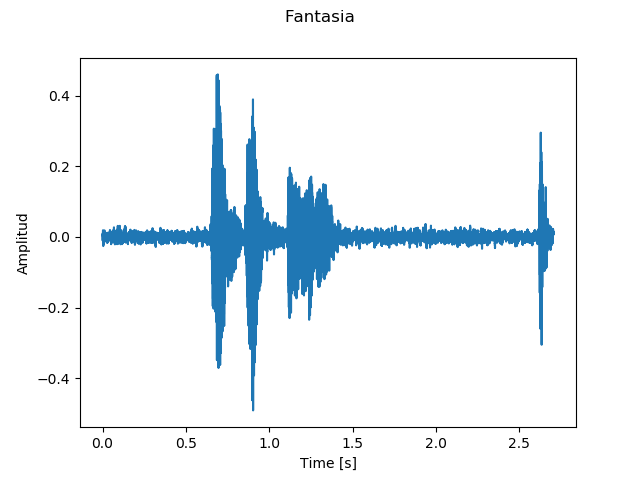

In [49]:
plot(x, Fs)

<IPython.core.display.Javascript object>


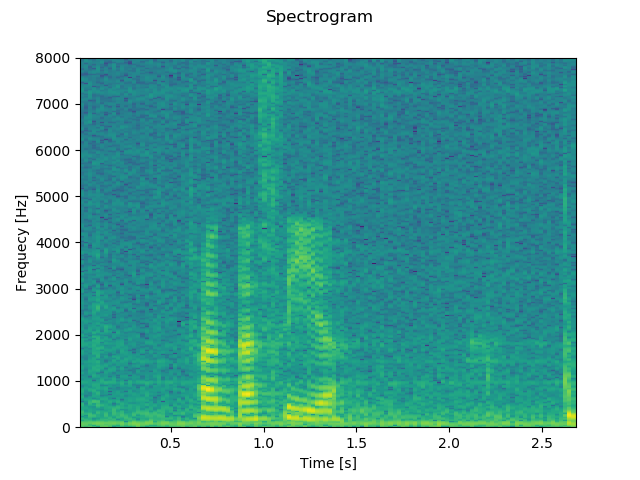

In [35]:
plot_spectrogram(x, Fs)

<IPython.core.display.Javascript object>


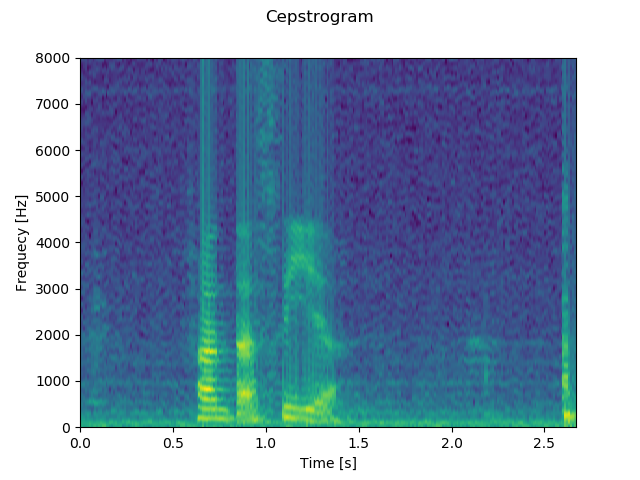

In [37]:
plot_cepstrogram(x, Fs)

<IPython.core.display.Javascript object>


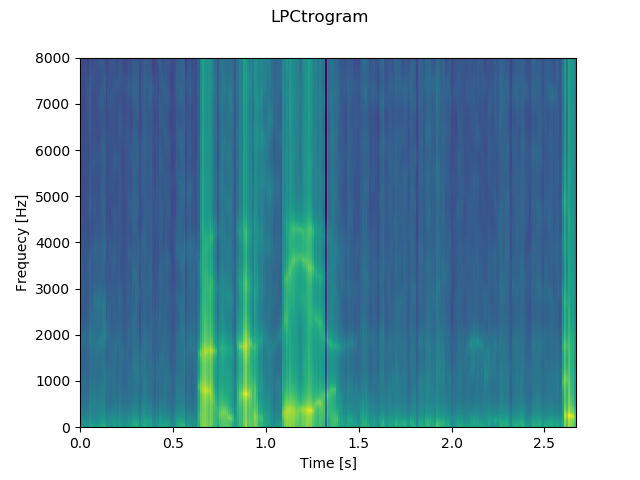

In [38]:
plot_lpctrogram(x, Fs)